<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/0312_pre_js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 드라이브 마운트

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

In [6]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

## 데이터 구성

In [61]:
df = pd.read_csv("/content/drive/MyDrive/PABA/data_file/SCALE불량.csv", encoding = 'euc_kr')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


## 데이터 전처리

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

### 목적 변수

In [63]:
# df['scale'] = df['scale'].map(lambda x : 0 if x == "양품" else 1)
# df.head()

### 명목형 변수

#### rolling_date

*  7-19시를 주간, 19-7시를 야간으로 변환

In [64]:
# rolling_date 열을 datetime 객체로 변환
df['rolling_date'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S')

def transform_date(row):
    hour = row.hour
    if 7 <= hour < 19: return "주간"
    else: return "야간"

# '주간', '야간'으로 변경하면서 day_yn이라는 열 이름 새로 부여
df['day_yn'] = df['rolling_date'].apply(transform_date)
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,day_yn
0,PLT_1001,2023-01-03 07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,116,1133,59,259,1133,TMCP(온도제어),934,8,1조,주간
1,PLT_1002,2023-01-03 07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,122,1135,53,238,1135,TMCP(온도제어),937,8,1조,주간
2,PLT_1003,2023-01-03 07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,116,1121,55,258,1121,TMCP(온도제어),889,8,1조,주간
3,PLT_1004,2023-01-03 07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,125,1127,68,266,1127,TMCP(온도제어),885,8,1조,주간
4,PLT_1005,2023-01-03 07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,134,1128,48,246,1128,TMCP(온도제어),873,8,1조,주간


In [65]:
# 파생변수 day_yn 생성 후 rolling_date 삭제
df.drop(columns='rolling_date',inplace=True)

#### spec_long

<Axes: xlabel='spec_long', ylabel='count'>

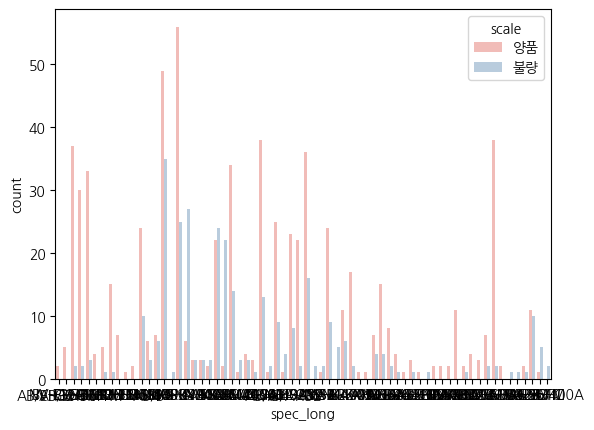

In [66]:
sns.countplot(x='spec_long', hue = 'scale', data = df)



*   그래프에 불량갯수가 더 많은 품목들도 있음
*   제품 규격의 종류가 많아서 어떤 제품 규격인지 보이지 않는 문제 발생
*   양품과 불량 제품을 따로 목록으로 출력해보기


In [67]:
# 양품보다 불량이 더 많은 후판 규격.
grouped = df.groupby(['spec_long', 'scale']).size().unstack(fill_value=0)
bad_more_than_good = grouped[grouped['불량'] > grouped['양품']].index.tolist()
bad_more_than_good

['A131-DH36TM',
 'A283-C',
 'A516-60',
 'BV-AH36-TM',
 'CCS-B',
 'JS-SM400A',
 'JS-SM490A',
 'JS-SM490YA',
 'JS-SS400',
 'KR-A',
 'KR-B',
 'KS-SM400A',
 'KS-SM490A',
 'KS-SS400',
 'LR-EH32-TM',
 'NV-B']

*  불량이 더 많은 규격의 특징을 파악해볼 수 있음

#### spec_country

<Axes: xlabel='spec_country', ylabel='count'>

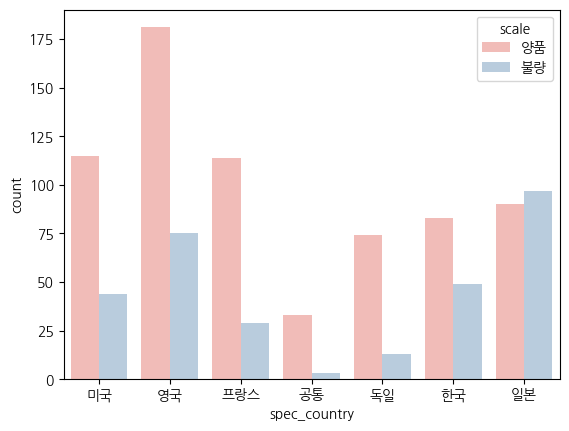

In [68]:
# 나라 규격에 따른 후판 불량 갯수 확인
sns.countplot(x='spec_country', hue = 'scale', data = df)

*   일본 규격으로 만들어진 후판은 불량품이 더 많음
*   불량으로 만들어진 특정 두께, 폭, 길이가 있는지 파악해볼 수 있음


#### plate_no

*  고유값인 plate_no는 삭제

In [69]:
df.drop("plate_no", axis = 1, inplace = True)

#### steel_kind

<Axes: xlabel='steel_kind', ylabel='count'>

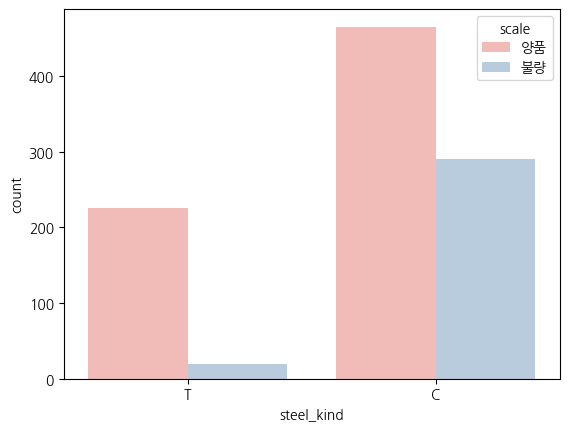

In [70]:
# 강종별 Scale 유무 관계
sns.countplot(x='steel_kind', hue = 'scale', data = df)

*   탄소강(C)이 티타늄강(T)보다 훨씬 불량률이 높음
*   이유: 티타늄이 들어가면 철이 산소랑 반응을 못하게 막음

#### hsb

<Axes: xlabel='hsb', ylabel='Count'>

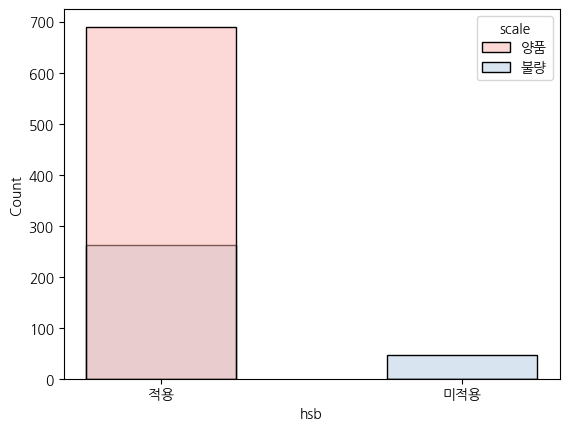

In [71]:
# HSB 적용에 따른 후판 분포 확인
sns.histplot(x= "hsb", hue = "scale", data = df, shrink=0.5)

*   HSB 미적용 후판은 모두 불량인걸로 파악
*   HSB를 적용했음에도 불량으로 나온 후판은 적용 막대 진한 핑크



In [72]:
# HSB 미적용 제거
idx = df[df['hsb'] == "미적용"].index
df.drop(idx, inplace=True)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,day_yn
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,116,1133,59,259,1133,TMCP(온도제어),934,8,1조,주간
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,122,1135,53,238,1135,TMCP(온도제어),937,8,1조,주간
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,116,1121,55,258,1121,TMCP(온도제어),889,8,1조,주간
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,125,1127,68,266,1127,TMCP(온도제어),885,8,1조,주간
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,...,134,1128,48,246,1128,TMCP(온도제어),873,8,1조,주간


#### fur_no

<Axes: xlabel='fur_no', ylabel='count'>

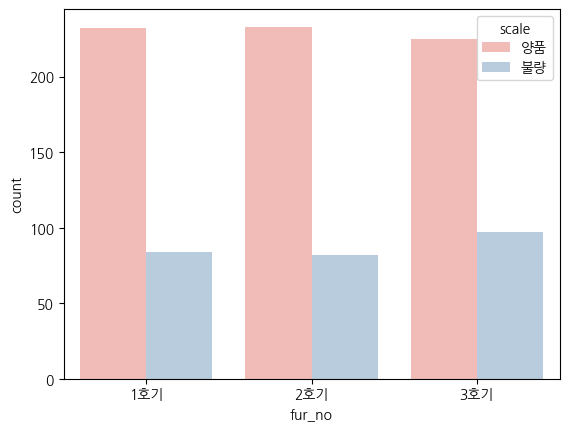

In [73]:
# 가열로 호기에 따라 불량 갯수 확인
sns.countplot(x='fur_no', hue = 'scale', data = df)


*   가열로 호기 차이에 따라 불량률이 크게 차이나지 않음

#### fur_input_row

<Axes: xlabel='fur_input_row', ylabel='count'>

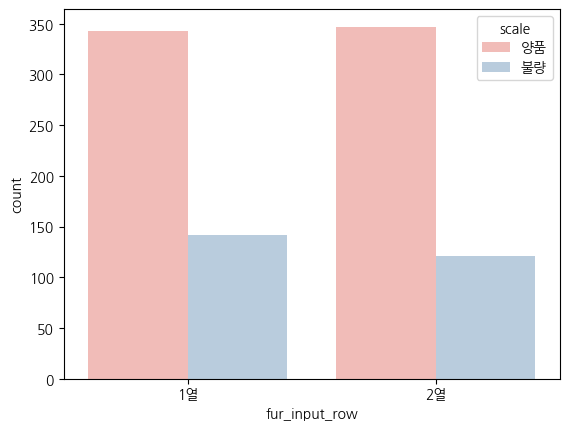

In [74]:
# 가열로 장입열에 따른 불량 갯수 확인
sns.countplot(x='fur_input_row', hue = 'scale', data = df)


*   가열로 장입열 차이에 따라 생기는 불량률은 크게 차이나지 않음

#### rolling_method

<Axes: xlabel='rolling_method', ylabel='count'>

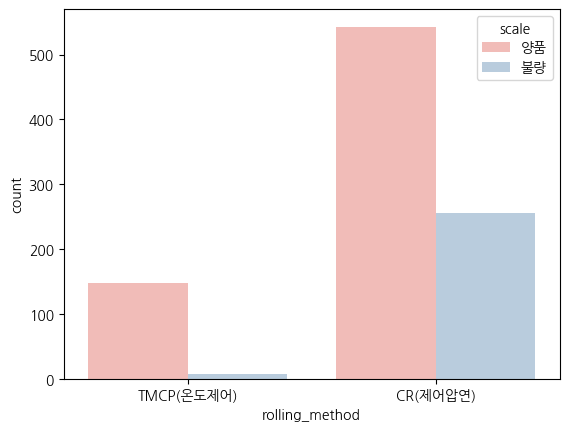

In [75]:
# 압연방법에 따른 불량 갯수 확인
sns.countplot(x='rolling_method', hue = 'scale', data = df)

*   제어압연으로 압연한 후판이 불량률이 훨씬 높음
*   제어압연(천천히 냉각), TMCP(급냉시키기)

#### work_group

<Axes: xlabel='work_group', ylabel='count'>

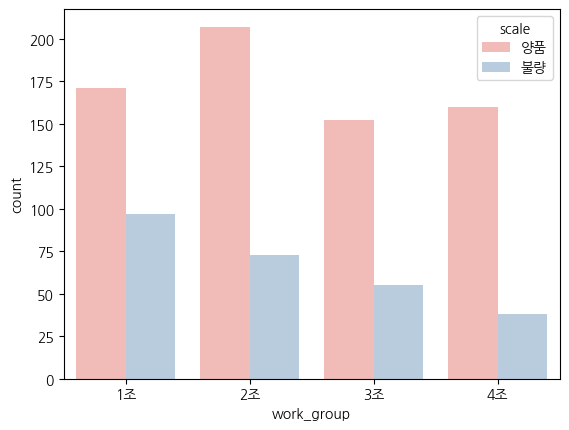

In [76]:
# 작업조에 따른 불량 갯수 확인
sns.countplot(x='work_group', hue = 'scale', data = df)

In [77]:
# 조별 불량률
df['scale'] = df['scale'].map(lambda x : 0 if x == "양품" else 1)
df_groups = df.groupby(["work_group"])["scale"]
print(df_groups)
df_w = pd.DataFrame(columns = ["work_group", "PROB"])
for name, g in df_groups:
    df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
df_w

,work_group,PROB
0,1조,0.361940
1,2조,0.260714
2,3조,0.265700
3,4조,0.191919


*   조마다 불량률이 다름
    *   이유가 있는지? 4조 2교대 (7, 19시 기준 변경)
*   다른 변수들과의 관계(근무시간 등) 더 찾아보면 연관성을 찾을거라 예상
*   각 조마다 불량갯수를 비율로 나타내면 1, 3, 2, 4 순으로 불량률이 높음

##### work_group, day_yn 분할표

In [78]:
crosstab = pd.crosstab(df['day_yn'], df['work_group'], margins=True)
crosstab

work_group,1조,2조,3조,4조,All
day_yn,,,,,
야간,0,280,0,198,478
주간,268,0,207,0,475
All,268,280,207,198,953


*  1, 3조는 주간에 근무하고 2, 4조는 야간에 근무  
    -> 불량률이 높은 1, 3조가 같은 시간에 일하고 상대적으로 불량률이 낮은 2, 4조가 야간에 일했음을 확인  
    -> work_group 열을 제거하고 day_yn 열을 이용해 주간, 야간을 기준으로 불량 이유를 찾아본다.

In [79]:
# work_group 열 제거
df.drop(columns='work_group',inplace=True)

#### 변수 처리

In [80]:
# 단위가 같이 표현되어 있는 수치형 변수 처리  (fur_no, fur_input_row)
df['fur_no'] = df['fur_no'].str.replace('호기', '')
df['fur_input_row'] = df['fur_input_row'].str.replace('열', '')

#### 변수 검정

In [81]:
# 검정 결과를 저장할 딕셔너리 생성
chi2_results = {}

# 명목형 변수 간 카이제곱 검정을 위한 변수 리스트
variables = ['steel_kind', 'fur_no', 'fur_input_row', 'rolling_method', 'day_yn']

for var in variables:
    # 교차 테이블 생성
    cross_tab = pd.crosstab(df[var], df['scale'])
    # 카이제곱 검정 수행
    chi2, p, dof, expected = chi2_contingency(cross_tab)
    # 결과 저장
    chi2_results[var] = {'chi2': chi2, 'p-value': p, 'dof': dof}

# 검정 결과 출력
for var, result in chi2_results.items():

    print(f"{var}와 scale:")
    print(f"  카이제곱 통계량: {result['chi2']:.2f}")
    print(f"  p-value: {result['p-value']}")
    print(f"  자유도(dof): {result['dof']}\n")

steel_kind와 scale:
  카이제곱 통계량: 83.51
  p-value: 6.344605892246456e-20
  자유도(dof): 1

fur_no와 scale:
  카이제곱 통계량: 1.58
  p-value: 0.4542212948451264
  자유도(dof): 2

fur_input_row와 scale:
  카이제곱 통계량: 1.23
  p-value: 0.26719421459266435
  자유도(dof): 1

rolling_method와 scale:
  카이제곱 통계량: 47.48
  p-value: 5.551000932469287e-12
  자유도(dof): 1

day_yn와 scale:
  카이제곱 통계량: 8.75
  p-value: 0.0030892317474954275
  자유도(dof): 1



### 숫자형 변수

#### pt_thick

#### pt_width

#### pt_length

#### fur_heat_temp

<Axes: xlabel='scale', ylabel='fur_heat_temp'>

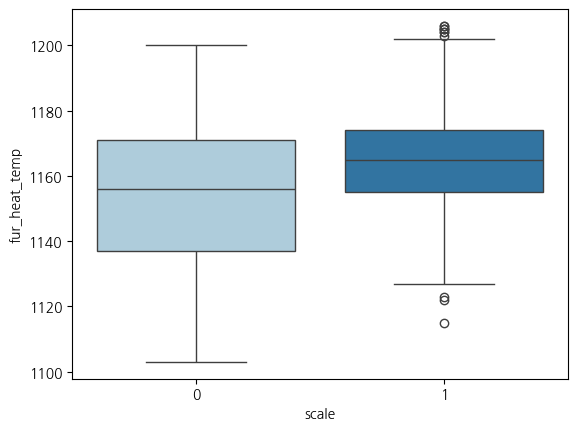

In [82]:
# 가열대 소재온도와 Scale 유무 관계
sns.boxplot(y = 'fur_heat_temp', x = 'scale' , data = df,palette=palette)

*   가열로 가열대 소재온도 (들어갔을 때를 기준이라고 판단)
*   가열대 소재온도랑 불량 유무의 관계를 결정하기엔 어렵다고 판단

<Axes: xlabel='fur_heat_temp', ylabel='Count'>

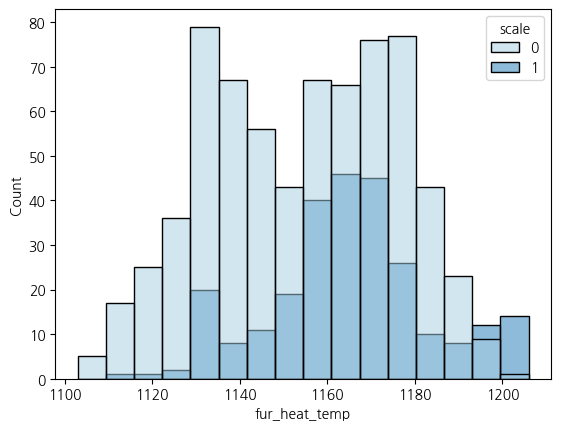

In [29]:
# 가열대 소재온도와 Scale 유무 확인
sns.histplot(x = 'fur_heat_temp', hue = 'scale' , data = df,palette=palette)



*   양품과 불량품의 흐름이 비슷하다고 판단해 가열대 소재온도와 Scale 유무의 관계를 결정하기엔 어렵다고 판단



#### fur_heat_time

<Axes: xlabel='scale', ylabel='fur_heat_time'>

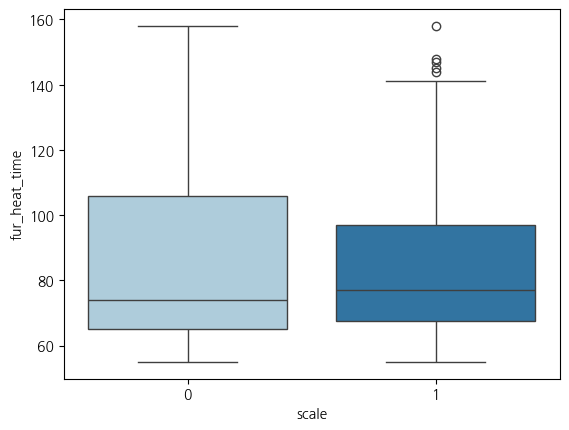

In [30]:
# 가열대 재로시간과 Scale 유무 관계
sns.boxplot(y = 'fur_heat_time', x = 'scale' , data = df ,palette=palette)

*   중앙값을 중심으로 값의 분포가 비대칭  
*   중앙값이 평균보다 작음

<Axes: xlabel='fur_heat_time', ylabel='Count'>

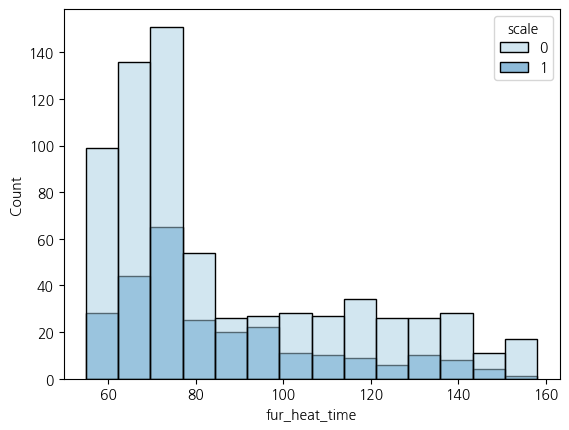

In [31]:
# 가열대 재로시간과 Scale 유무 확인
sns.histplot(x = 'fur_heat_time', hue = 'scale' , data = df,palette=palette)

#### fur_soak_temp

<Axes: xlabel='scale', ylabel='fur_soak_temp'>

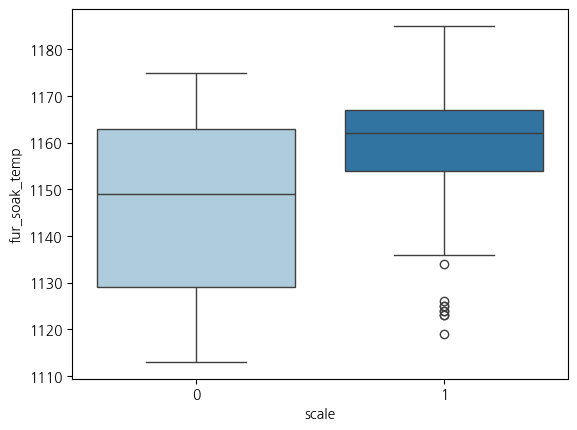

In [32]:
# 균열대 소재온도와 Sclae 유무 관계
sns.boxplot(y = 'fur_soak_temp', x = 'scale' , data = df ,palette=palette)

*   불량의 이상치가 많음
*   불량인 후판은 대부분 균열대로 갔을 때 온도가 높은 후판들이 Scale이 될 확률이 높음  
    -> 온도가 낮음에도 불량품이 되는 다른 이유가 있을 수 있다는 점을 알게됨

#### fur_soak_time

#### fur_total_time

<Axes: xlabel='scale', ylabel='fur_total_time'>

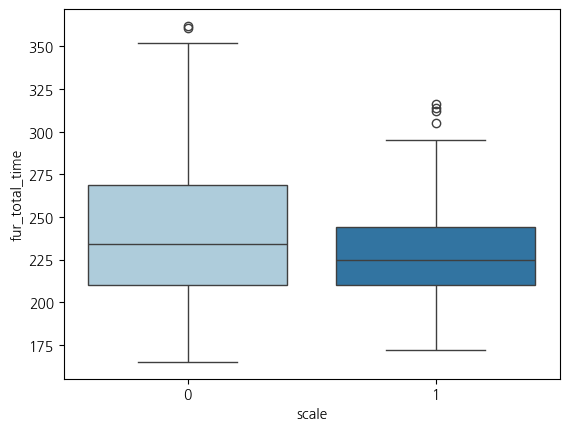

In [33]:
# 가열로 총 재로시간과 Scale 유무 관계
sns.boxplot(y = 'fur_total_time', x = 'scale' , data = df ,palette=palette)



*   가열로 총 재로시간에서 모든 불량품은 양품의 범위 안에 들어가있기에 총 재로시간과 Scale 유무의 관계를 결정하기엔 어렵다고 판단



#### fur_ex_temp

<Axes: xlabel='scale', ylabel='fur_ex_temp'>

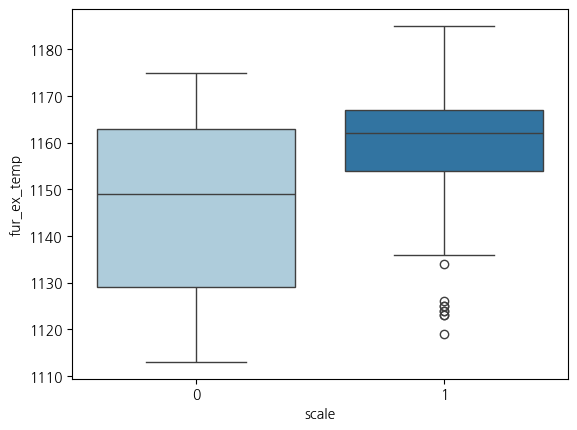

In [34]:
# 가열로 추출온도와 Scale 유무 관계
sns.boxplot(y = 'fur_ex_temp', x = 'scale' , data = df ,palette=palette)


*   불량 후판은 가열로 추출온도가 훨씬 높음
*   낮은 온도에서 Scale이 생긴 후판은 이상치로 잡힘  
    -> 대부분의 Scale은 높은 온도에서 생긴다는 가정을 만들 수 있음

<Axes: xlabel='fur_soak_temp', ylabel='fur_ex_temp'>

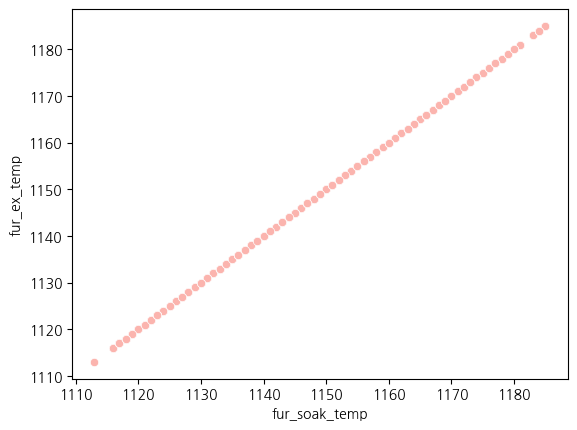

In [35]:
# 균열대 재로시간, 총 재로시간 그래프
sns.scatterplot(data=df, x="fur_soak_temp", y="fur_ex_temp")

*   균열대 재로시간과 총 재로시간은 y = x의 관계를 가지기 때문에 하나의 열로 관리  
    -> fur_ex_temp(가열로 추출온도)를 제거

In [36]:
df.drop("fur_ex_temp", axis = 1, inplace = True)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,night_yn
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간


#### rolling_temp

<Axes: xlabel='scale', ylabel='rolling_temp'>

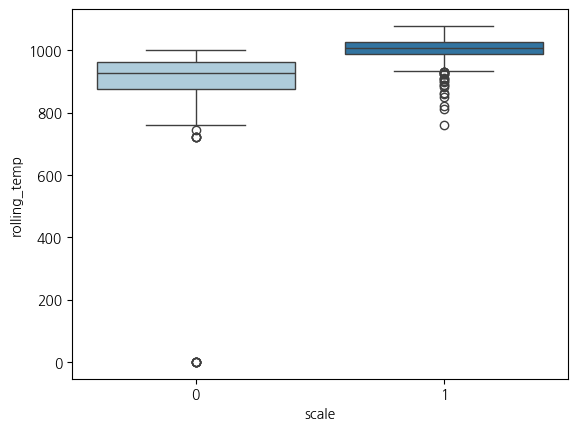

In [37]:
# 압연온도와 Scale 유무 관계
sns.boxplot(y = 'rolling_temp', x = 'scale' , data = df,palette=palette )

*   압연온도가 0도인 양품이 있음 (이상치 확인)

In [38]:
df[df['rolling_temp']==0]

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,night_yn
53,0,GL-E36-TM,독일,T,56,3800,11400,적용,3,2,1132,95,1128,80,244,TMCP(온도제어),0,6,주간
221,0,JS-SM490YB,일본,C,16,2200,43600,적용,3,2,1163,57,1166,67,228,CR(제어압연),0,10,야간
222,0,JS-SM490YB,일본,C,16,2200,43600,적용,3,1,1169,64,1164,61,188,CR(제어압연),0,10,야간
598,0,PILAC-BT33,한국,T,81,2100,12900,적용,2,1,1133,89,1122,59,229,CR(제어압연),0,6,주간
599,0,PILAC-BT33,한국,T,81,2100,13200,적용,1,2,1130,92,1124,61,210,CR(제어압연),0,6,주간
600,0,NV-D32-TM,영국,T,40,2500,23600,적용,3,1,1119,109,1117,76,260,TMCP(온도제어),0,6,주간


*  rolling_temp에 0인 6개의 행 존재  
*  이 값을 대체할 근거가 마땅하지 않음  
    -> 제거

In [39]:
# 0인 행 제거
df = df[df['rolling_temp'] != 0]

<Axes: xlabel='scale', ylabel='rolling_temp'>

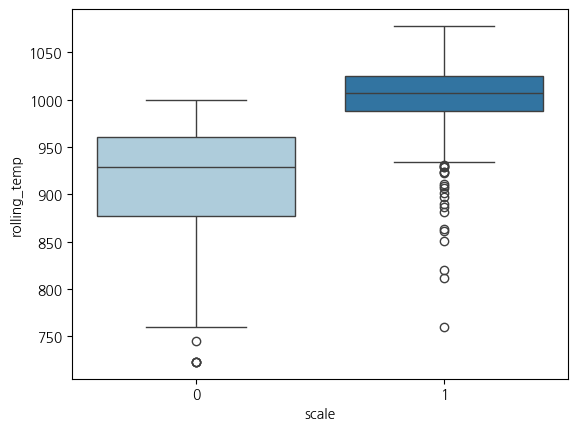

In [40]:
# 삭제 후 boxplot 확인
sns.boxplot(y = 'rolling_temp', x = 'scale' , data = df,palette=palette )



*   양품의 온도보다 높은 온도에서 압연을 할 시, 불량품이 될 확률 증가



#### descaling_count

#### 변수 검정

In [41]:
# 연속형 변수 검정 진행
variables = [
    "pt_thick", "pt_width", "pt_length",
    "fur_heat_temp", "fur_heat_time", "fur_soak_time",
    "fur_total_time", "rolling_temp"
]

# 결과를 저장할 딕셔너리 초기화
final_results = {}

for var in variables:
    # '양품'과 '불량' 데이터 분리
    data_good = df[df['scale'] == 0][var]
    data_bad = df[df['scale'] == 1][var]

    # 정규성 검정 (Shapiro-Wilk test)
    normality_good = shapiro(data_good)
    normality_bad = shapiro(data_bad)

    # 등분산성 검정 (Levene's test)
    equal_var_test = levene(data_good, data_bad)

    # Two-sample t-test (등분산 가정하지 않음)
    ttest_result = ttest_ind(data_good, data_bad, equal_var=False)

    # 결과 저장
    final_results[var] = {
        'normality_p_good': normality_good.pvalue,
        'normality_p_bad': normality_bad.pvalue,
        'levene_p': equal_var_test.pvalue,
        'ttest_p': ttest_result.pvalue
    }

# 결과 출력
for var, results in final_results.items():
    print(f"{var}:")
    print(f"  Shapiro-Wilk Test - Good: p={results['normality_p_good']:.2e}, Bad: p={results['normality_p_bad']:.2e}")
    print(f"  Levene's Test: p={results['levene_p']:.2e}")
    print(f"  T-Test: p={results['ttest_p']:.2e}\n")

pt_thick:
  Shapiro-Wilk Test - Good: p=2.57e-30, Bad: p=1.12e-22
  Levene's Test: p=2.69e-10
  T-Test: p=1.02e-04

pt_width:
  Shapiro-Wilk Test - Good: p=7.94e-08, Bad: p=3.14e-13
  Levene's Test: p=1.52e-01
  T-Test: p=1.54e-11

pt_length:
  Shapiro-Wilk Test - Good: p=3.44e-22, Bad: p=7.51e-07
  Levene's Test: p=7.66e-22
  T-Test: p=1.17e-01

fur_heat_temp:
  Shapiro-Wilk Test - Good: p=6.05e-09, Bad: p=4.31e-04
  Levene's Test: p=3.98e-06
  T-Test: p=9.71e-14

fur_heat_time:
  Shapiro-Wilk Test - Good: p=1.28e-24, Bad: p=3.25e-13
  Levene's Test: p=2.76e-02
  T-Test: p=3.63e-01

fur_soak_time:
  Shapiro-Wilk Test - Good: p=5.92e-19, Bad: p=2.90e-09
  Levene's Test: p=8.13e-10
  T-Test: p=1.25e-19

fur_total_time:
  Shapiro-Wilk Test - Good: p=1.61e-12, Bad: p=1.07e-06
  Levene's Test: p=5.65e-12
  T-Test: p=3.87e-07

rolling_temp:
  Shapiro-Wilk Test - Good: p=3.52e-14, Bad: p=1.40e-15
  Levene's Test: p=7.33e-12
  T-Test: p=2.72e-84



# 철강 규격별 용도 분류

In [42]:
# 용도에 따른 철강 규격 데이터
steel_spec = [
    "A131-DH36TM 선체구조용(조선용)",
    "BV-AH36-TL 선체구조용(조선용)",
    "SA283-C 용접구조용",
    "A283-C 보일러및압력용기용",
    "JS-SM400A 용접구조용",
    "NK-KD36-TM 선체구조용(조선용)",
    "GL-D36-TM 선체구조용(조선용)",
    "PILAC-BT33 구조용압연강재",
    "NV-A36-TM 선체구조용(조선용)",
    "BV-AH36-TM 선체구조용(조선용)",
    "KS-HSB500 교량구조용",
    "API-2W-50T 해양구조용",
    "GL-A36-TM 선체구조용(조선용)",
    "NV-A32-TM 선체구조용(조선용)",
    "NV-D32-TM 선체구조용(조선용)",
    "NK-KA32-TM 선체구조용(조선용)",
    "GL-A32-TM 선체구조용(조선용)",
    "LR-AH36-TM 선체구조용(조선용)",
    "LR-EH32-TM 선체구조용(조선용)",
    "NV-E32-TM 선체구조용(조선용)",
    "AB/EH32-TM 선체구조용(조선용)",
    "NV-E36-TM 선체구조용(조선용)",
    "BV-EH36-TM 선체구조용(조선용)",
    "AB/EH36-TM 선체구조용(조선용)",
    "BV-AH32-TM 선체구조용(조선용)",
    "GL-E32-TM 선체구조용(조선용)",
    "GL-E36-TM 선체구조용(조선용)",
    "BV-EH32-TM 선체구조용(조선용)",
    "KS-HSB600 교량구조용",
    "LR-EH36-TM 선체구조용(조선용)",
    "BV-B 선체구조용(조선용)",
    "AB/B 선체구조용(조선용)",
    "LR-B 선체구조용(조선용)",
    "JS-SM490YB 용접구조용",
    "KR-B 선체구조용(조선용)",
    "LR-A 선체구조용(조선용)",
    "JS-SM490A 용접구조용",
    "KS-SM400B 용접구조용",
    "JS-SM400B 용접구조용",
    "KS-SS400 일반구조용",
    "KR-A 선체구조용(조선용)",
    "JS-SS400 일반구조용",
    "NV-A 선체구조용(조선용)",
    "KS-SM400A 용접구조용",
    "KS-SM490B 용접구조용",
    "V42JBN3 선체구조용(조선용)",
    "AB/A 선체구조용(조선용)",
    "A516-60 보일러및압력용기용",
    "BV-AH32 선체구조용(조선용)",
    "JS-SM490YA 용접구조용",
    "AB/AH32 선체구조용(조선용)",
    "GL-A32 선체구조용(조선용)",
    "LR-AH32 선체구조용(조선용)",
    "CCS-B 선체구조용(조선용)",
    "NV-B 선체구조용(조선용)",
    "NV-A32 선체구조용(조선용)",
    "KS-SM490A 용접구조용",
    "GL-A 선체구조용(조선용)",
    "NK-KA32 선체구조용(조선용)",
    "LR-AH36 선체구조용(조선용)",
    "A709-36 교량구조용",
    "KR-AH32 선체구조용(조선용)",
    "BV-A 선체구조용(조선용)",
    "NK-KA 선체구조용(조선용)",
    "NV-D36-TM 선체구조용(조선용)"
]

In [83]:
# 규격과 용도에 맞게 분리 후 Dictionary로 저장
steel_spec_dict_updated = {spec.split(" ")[0]: " ".join(spec.split(" ")[1:]) for spec in steel_spec}

{'A131-DH36TM': '선체구조용(조선용)',
 'BV-AH36-TL': '선체구조용(조선용)',
 'SA283-C': '용접구조용',
 'A283-C': '보일러및압력용기용',
 'JS-SM400A': '용접구조용',
 'NK-KD36-TM': '선체구조용(조선용)',
 'GL-D36-TM': '선체구조용(조선용)',
 'PILAC-BT33': '구조용압연강재',
 'NV-A36-TM': '선체구조용(조선용)',
 'BV-AH36-TM': '선체구조용(조선용)',
 'KS-HSB500': '교량구조용',
 'API-2W-50T': '해양구조용',
 'GL-A36-TM': '선체구조용(조선용)',
 'NV-A32-TM': '선체구조용(조선용)',
 'NV-D32-TM': '선체구조용(조선용)',
 'NK-KA32-TM': '선체구조용(조선용)',
 'GL-A32-TM': '선체구조용(조선용)',
 'LR-AH36-TM': '선체구조용(조선용)',
 'LR-EH32-TM': '선체구조용(조선용)',
 'NV-E32-TM': '선체구조용(조선용)',
 'AB/EH32-TM': '선체구조용(조선용)',
 'NV-E36-TM': '선체구조용(조선용)',
 'BV-EH36-TM': '선체구조용(조선용)',
 'AB/EH36-TM': '선체구조용(조선용)',
 'BV-AH32-TM': '선체구조용(조선용)',
 'GL-E32-TM': '선체구조용(조선용)',
 'GL-E36-TM': '선체구조용(조선용)',
 'BV-EH32-TM': '선체구조용(조선용)',
 'KS-HSB600': '교량구조용',
 'LR-EH36-TM': '선체구조용(조선용)',
 'BV-B': '선체구조용(조선용)',
 'AB/B': '선체구조용(조선용)',
 'LR-B': '선체구조용(조선용)',
 'JS-SM490YB': '용접구조용',
 'KR-B': '선체구조용(조선용)',
 'LR-A': '선체구조용(조선용)',
 'JS-SM490A': '용접구조용',
 'KS-SM400B': '용

In [44]:
# spec_long 열에서 COMMON(공통)인 행은 purpose에 COMMON으로 추가
purpose_list = []
for i in df['spec_long']:
    tmp = steel_spec_dict_updated.get(i, "COMMON")
    purpose_list.append(tmp)

df['purpose'] = purpose_list
df[['spec_long','purpose']].head(20)

,spec_long,purpose
0,AB/EH32-TM,선체구조용(조선용)
1,AB/EH32-TM,선체구조용(조선용)
2,NV-E36-TM,선체구조용(조선용)
3,NV-E36-TM,선체구조용(조선용)
4,BV-EH36-TM,선체구조용(조선용)
5,BV-EH36-TM,선체구조용(조선용)
6,BV-EH36-TM,선체구조용(조선용)
7,BV-EH36-TM,선체구조용(조선용)
8,BV-EH36-TM,선체구조용(조선용)
9,AB/EH36-TM,선체구조용(조선용)


In [45]:
# 규격별 양품과 불량 비율
pd.DataFrame(df.groupby("purpose")['scale'].value_counts(normalize=True))

scale
purpose    scale          
COMMON     0      0.916667
           1      0.083333
교량구조용      0      1.000000
구조용압연강재    0      1.000000
보일러및압력용기용  1      0.750000
           0      0.250000
선체구조용(조선용) 0      0.792481
           1      0.207519
용접구조용      1      0.544910
           0      0.455090
일반구조용      1      0.862069
           0      0.137931
해양구조용      0      1.000000

In [48]:
# 불량률이 높은 규격
specified_purposes = ['선체구조용(조선용)', '용접구조용', '일반구조용']

# 불량률이 낮은 규격들은 OTHERS로 변경 (구조용압연강재, 보일러및압력용기용, 교량구조용, 해양구조용, COMMON)
df['purpose'] = df['purpose'].apply(lambda x: x if x in specified_purposes else 'OTHERS')

# Display the first few rows to verify the changes
df['purpose'].head()

0    선체구조용(조선용)
1    선체구조용(조선용)
2    선체구조용(조선용)
3    선체구조용(조선용)
4    선체구조용(조선용)
Name: purpose, dtype: object

In [49]:
df.purpose.unique()

array(['선체구조용(조선용)', 'OTHERS', '용접구조용', '일반구조용'], dtype=object)

In [50]:
df.columns

Index(['scale', 'spec_long', 'spec_country', 'steel_kind', 'pt_thick',
       'pt_width', 'pt_length', 'hsb', 'fur_no', 'fur_input_row',
       'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
       'fur_total_time', 'rolling_method', 'rolling_temp', 'descaling_count',
       'night_yn', 'purpose'],
      dtype='object')

### 결측치 확인

In [51]:
df.isnull().sum()

scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_method     0
rolling_temp       0
descaling_count    0
night_yn           0
purpose            0
dtype: int64



*   NaN값 존재하지 않음



### 설명변수간 관계

<Axes: >

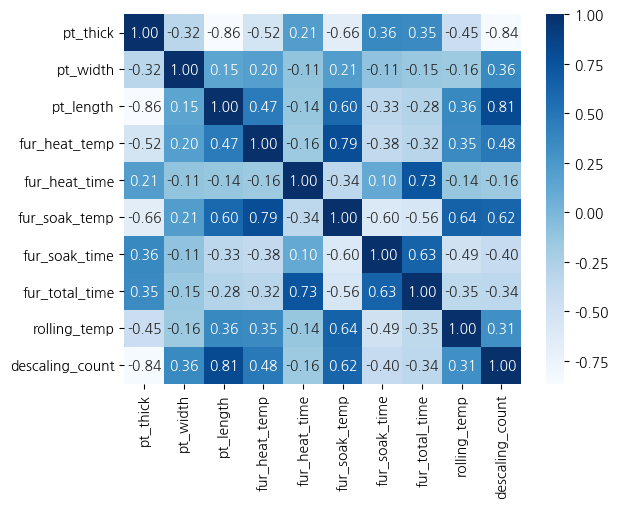

In [52]:
df_corr= df.drop(columns='scale').corr().round(3)
sns.heatmap(df_corr, annot = True, fmt = ".2f", cmap= "Blues")

- pt_length와 descaling_count의 상관계수: 0.81(양의 선형관계)
- pt_thick와 pt_length의 상관계수: -0.86(음의 선형관계)
- pt_thick와 descaling_count의 상관계수: -0.84(음의 선형관계)
- fur_heat_temp와 fur_soak_temp의 상관계수: 0.79(양의 선형관계)

In [53]:
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,night_yn,purpose
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,BV-A,프랑스,C,19,3400,41500,적용,1,2,1142,55,1151,86,203,CR(제어압연),948,10,야간,선체구조용(조선용)
996,0,LR-A,영국,C,19,3400,41500,적용,1,2,1142,55,1151,86,209,CR(제어압연),948,10,야간,선체구조용(조선용)
997,0,AB/AH32,미국,C,17,3400,43700,적용,2,2,1169,65,1163,77,227,CR(제어압연),948,10,야간,선체구조용(조선용)
998,0,NV-A32,영국,C,17,3400,43700,적용,2,2,1169,65,1163,77,204,CR(제어압연),948,10,야간,선체구조용(조선용)


<Axes: xlabel='fur_heat_temp', ylabel='fur_soak_temp'>

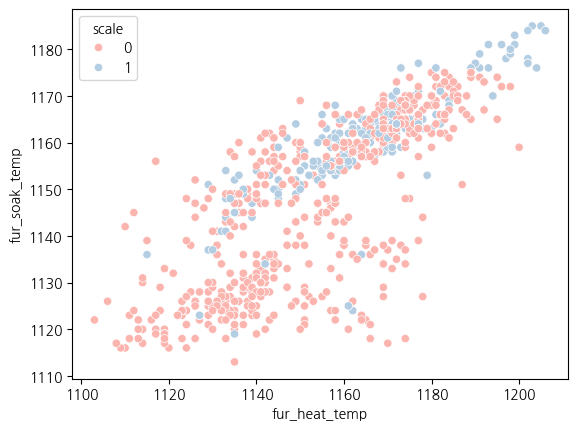

In [84]:
sns.scatterplot(data=df, x="fur_heat_temp", y="fur_soak_temp", hue="scale")

*   scale을 기준으로 서로 다른 양의 선형관계를 보이고있음
*   세부적으로 볼 필요 있음


<Axes: xlabel='descaling_count', ylabel='count'>

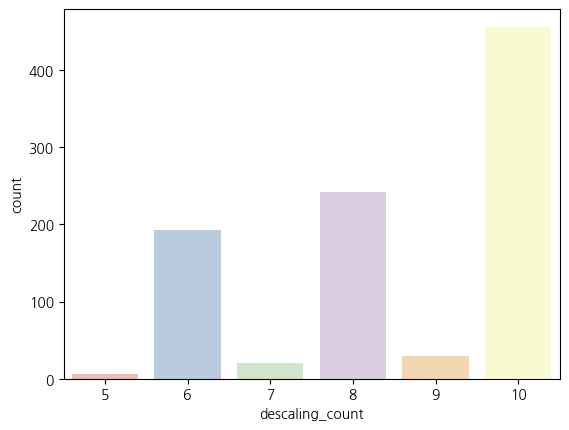

In [55]:
sns.countplot(data=df,x="descaling_count", palette=colors)

*   짝수로 할 경우 불량률이 높음

In [57]:
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,night_yn,purpose
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,BV-A,프랑스,C,19,3400,41500,적용,1,2,1142,55,1151,86,203,CR(제어압연),948,10,야간,선체구조용(조선용)
996,0,LR-A,영국,C,19,3400,41500,적용,1,2,1142,55,1151,86,209,CR(제어압연),948,10,야간,선체구조용(조선용)
997,0,AB/AH32,미국,C,17,3400,43700,적용,2,2,1169,65,1163,77,227,CR(제어압연),948,10,야간,선체구조용(조선용)
998,0,NV-A32,영국,C,17,3400,43700,적용,2,2,1169,65,1163,77,204,CR(제어압연),948,10,야간,선체구조용(조선용)


### 데이터 저장

In [58]:
# df.to_csv('final_scale.csv',index=False)

In [59]:
# zz=pd.read_csv('/content/final_scale.csv',encoding='utf-8')
# zz